# 3. ML data smoothing (harmonization) in columns

### main notebook: https://www.kaggle.com/artyomkolas/result-train-data-smoothing-algorithm

### 1st way: https://www.kaggle.com/artyomkolas/1-ml-data-smoothing-harmonization

### 2nd way: https://www.kaggle.com/artyomkolas/2-ml-data-smoothing-harmonization-with-contrib

### 3rd way: You see it now.




## Background

My first competition on kaggle started with a data frame with a lot of missing data, from 0.01% to 99.5% in about 30 columns. Housing Prices. The whole story began with my first ML algorithm for imputation nan into a raw data frame.

LinkedIn post: https://www.linkedin.com/posts/artyomkolas_hi-everyone-i-have-a-nice-news-i-tried-activity-6731588248403001344-Ggg9

notebook: https://www.kaggle.com/artyomkolas/ml-approach-to-replacing-nan-top-4

The essence of the algorithm is to imputation nan with more accurate values ​​in a raw data frame using ML and one click.
The algorithm showed excellent results and without any other improvements (default) of the data frame gave three results (top 11%, top 9%, top 4% in the Housing Prices leaderboard).

Applying other improvements, I was climbing on the leaderboard.
I was already very close to the top 1%. And I decided to very carefully and meticulously replace nan with more appropriate values ​​in each cell !!! without my algorithm with ML nan imputation. And what did I see ?!! The results in predictions (MAE) have become much worse!!!

For a long time I couldn’t understand: Why did the most logical values ​​turn out to be worse? Then he received new knowledge. Participated in new competitions. And I improved my ML nan impooter algorithm. 
Then I got new knowledge. Participated in new competitions. And I improved my ML nan impooter algorithm.


## Hypothesis

The other day the thought came that our world is not ideal. We raise or lower our expectations for purchases or sales, interviews, measurement errors and other factors. A kind of "imputation of subjectivity" and distortions, incl. add outliers.

A hypothesis appeared that the algorithm predicts and inserts, as it were, “more objective” values ​​instead of gaps in accordance with the general field of historical data (“averaged, more objective”). And thus improves the data field (better than real values).

Example: vector of a function (like price)
The lows and highs are the price values.
For example: [30,000, 40,000, 20,000, 23,000, ...]


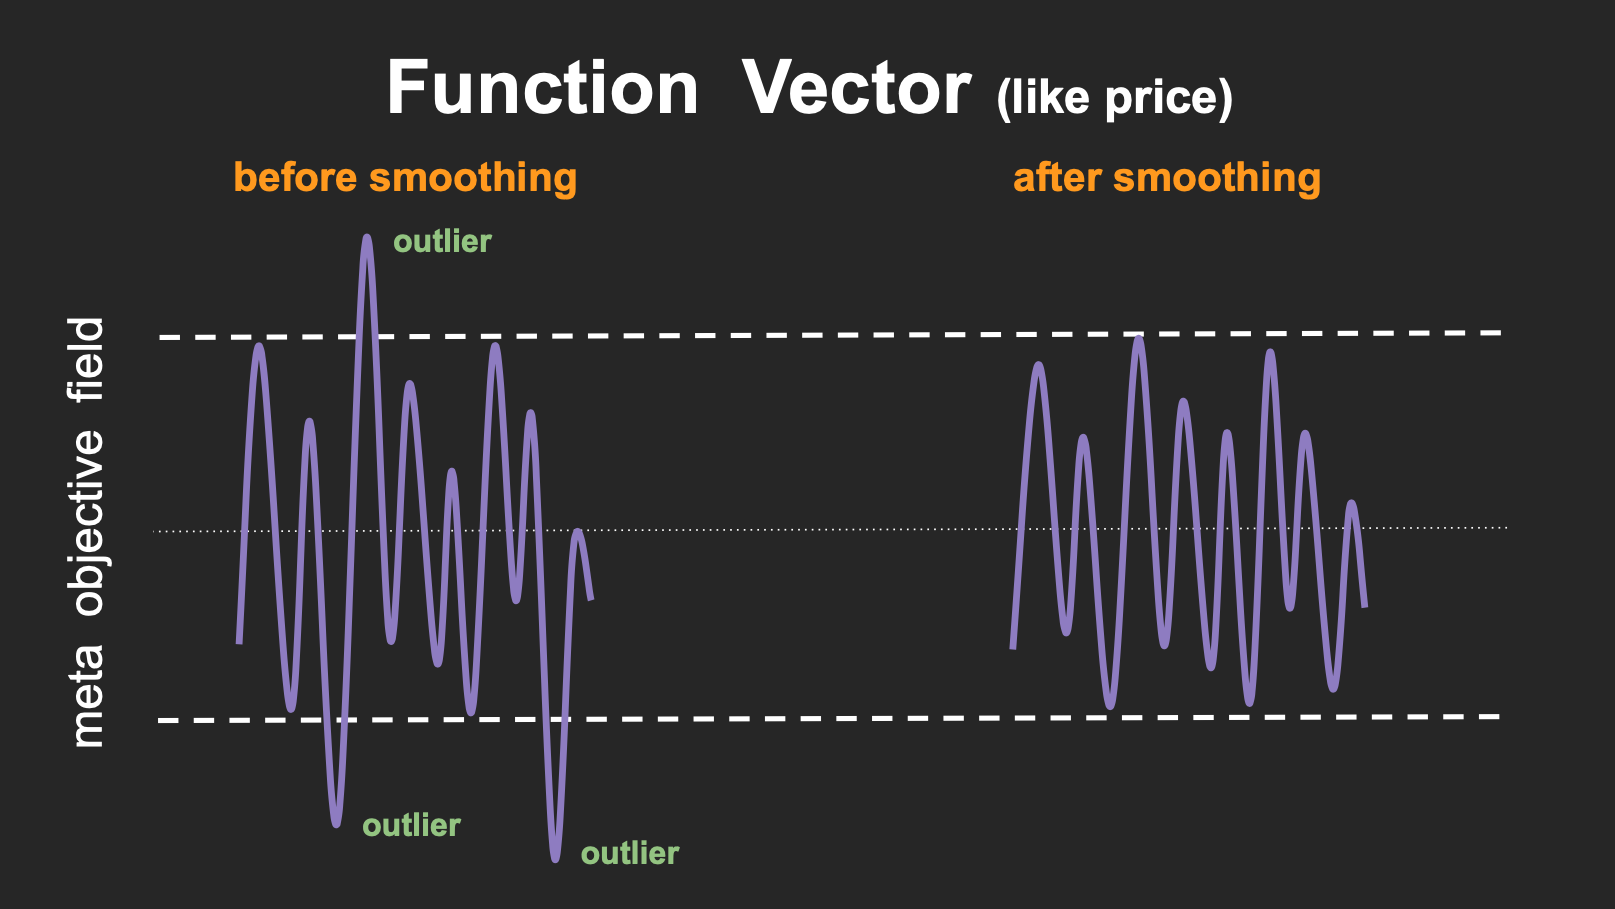

Well. But what if we go all over the data frame and iteratively delete 10% of the data, predict and impute it? Will this help to achieve data harmonization and will it add more objectivity? Will it improve the data for training the model? And finally, does it help train the model more accurately for practical purposes?

# Code

# Let's choose data, the target feature and middle of data¶
# 1005 rows!!! (autos.csv total 193 rows)

In [ ]:
import numpy as np
import pandas as pd


test_size_fraction = 0.5

num_rows = 1005 # all


#
data = "../input/fe-course-data/concrete.csv"
target_feature = "CompressiveStrength"



# data = "../input/fe-course-data/housing.csv"
# target_feature = "HouseAge"



# data = "../input/fe-course-data/autos.csv"     # ~ 15%
# target_feature = "price"








df = pd.read_csv(data)

df

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

In [ ]:
df = df.iloc[:][:num_rows]
df

# encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder


def encoding(df):
    for j in df.columns:
        el_type = df[j].dtype
        if el_type == 'object':
            df[j].replace(np.nan, 'NoNoNo', inplace=True)
            labelencoder = LabelEncoder()
            df.loc[:, j] = labelencoder.fit_transform(df.loc[:, j])
    return df

encoding(df)

# normalization

In [ ]:
predictors = list(df.columns)
predictors.remove(target_feature)

for col in predictors:
    min_x = df[[col]].min()
    max_x = df[[col]].max()
    df[[col]] = (df[[col]] - min_x) / (max_x - min_x)
df

# Let's split data to train and test.

In [ ]:
from sklearn.model_selection import train_test_split


predictors = list(df.columns)
predictors.remove(target_feature)

X = df[predictors]
y = df[[target_feature]]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size_fraction, random_state=0)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)


print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

# MAE Baseline Score

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
def score(train_X, train_y, test_X, test_y):
    model = LGBMRegressor(random_state=0).fit(train_X, train_y)
    predict = model.predict(test_X)
    score = mean_absolute_error(predict, test_y)
    return score

# Data smoothing

In [ ]:
results = pd.DataFrame()
results.loc[0, 'score'] = score(train_X, train_y, test_X, test_y)


for col in df.columns:
    df_new = pd.concat([train_X,train_y], axis=1)
    X = df_new.copy()
    y = X.pop(col)
    
    model = LGBMRegressor(random_state=0).fit(X, y)
    new_col_values = model.predict(X)
    df_new[[col]] = new_col_values
    
    train_X = df_new.copy()
    train_y = train_X.pop(target_feature)

    results.loc[col, 'score'] = score(train_X, train_y, test_X, test_y)

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py


baseline = []
baseline.append(results.iloc[0,0])
for el in results.index[1:]:
    baseline.append(results.iloc[0,0])

trace1 = go.Scatter(
                x=results.index, 
                y=baseline, 
                name="without smoothing", 
                marker=dict(color = '#FFB3F7',
                         line=dict(color='#000000',width=1)))

trace2 = go.Scatter(
                x=results.index, 
                y=results['score'], 
                name="smoothing iterations", 
                marker=dict(color = '#47E0FF',
                         line=dict(color='#000000',width=1)))

layout = go.Layout(hovermode='closest', 
               title = f'MAE after every iteration for feature: "{target_feature}"' ,
               xaxis = dict(title = 'smoothed data, columns'), 
               yaxis = dict(title = 'Mean Absolute Error'), 
               template= "plotly_dark")

fig = go.Figure(data = [trace1, trace2], layout=layout)
fig.show()

### AND for 
### data = "../input/fe-course-data/housing.csv"
### target_feature = "HouseAge"

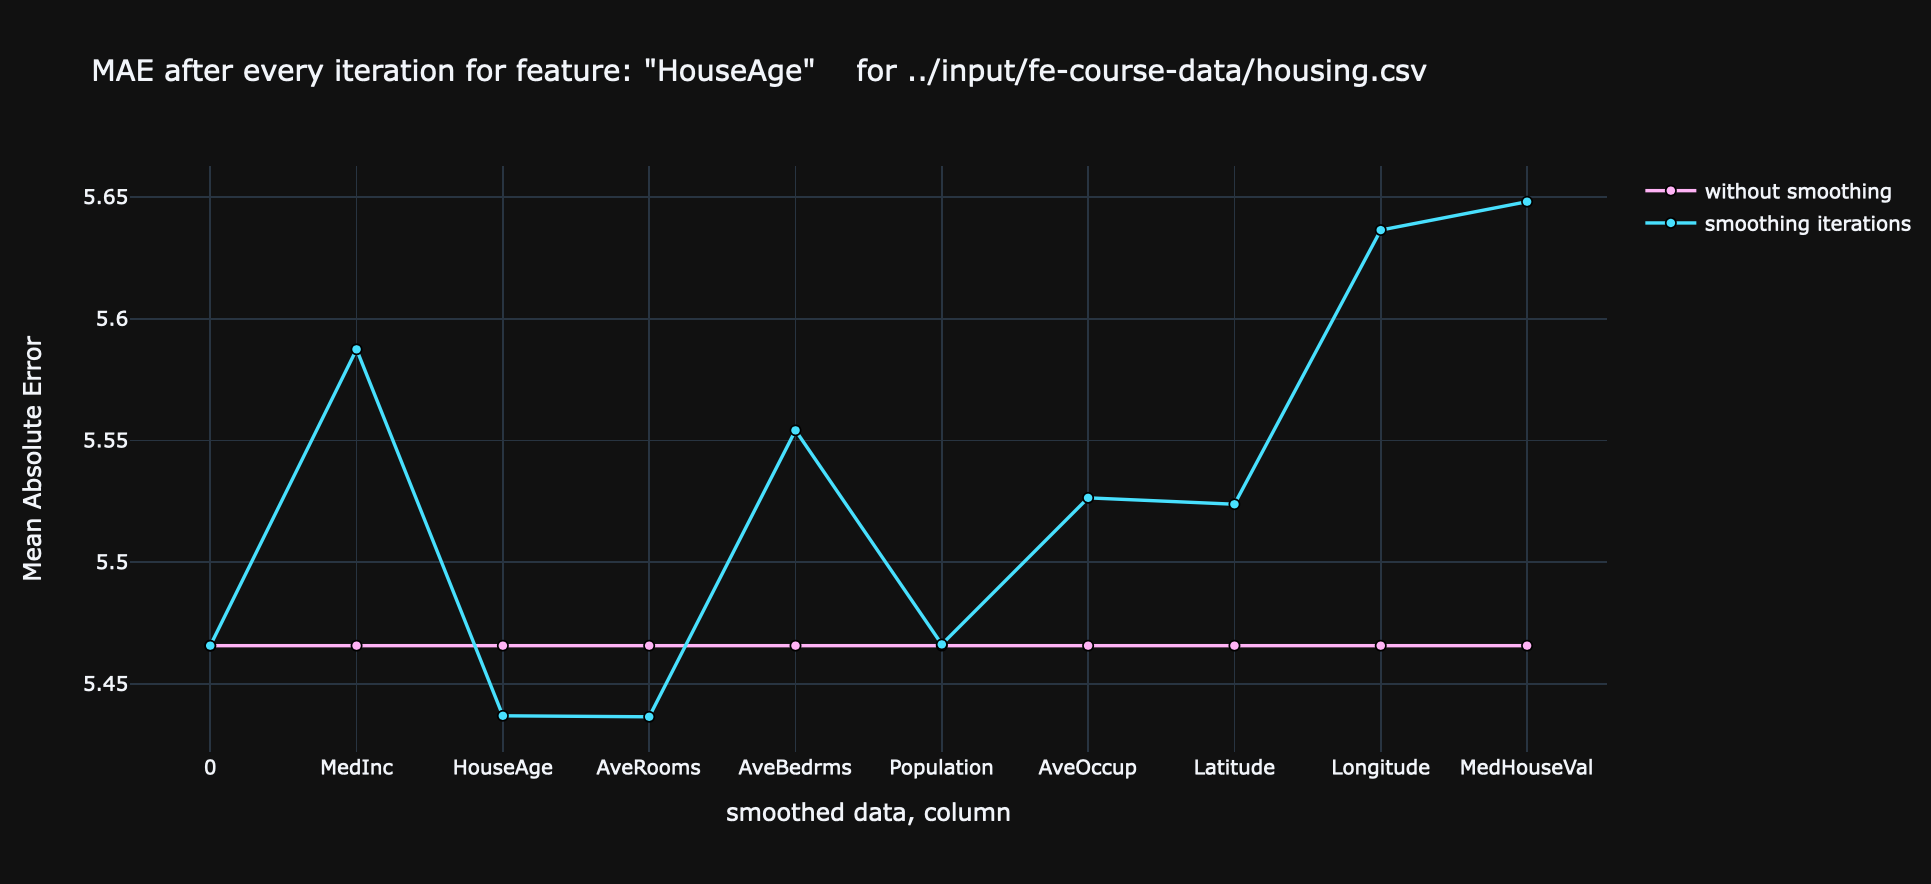

### AND for 
### data = "../input/fe-course-data/autos.csv" 
### target_feature = "price"

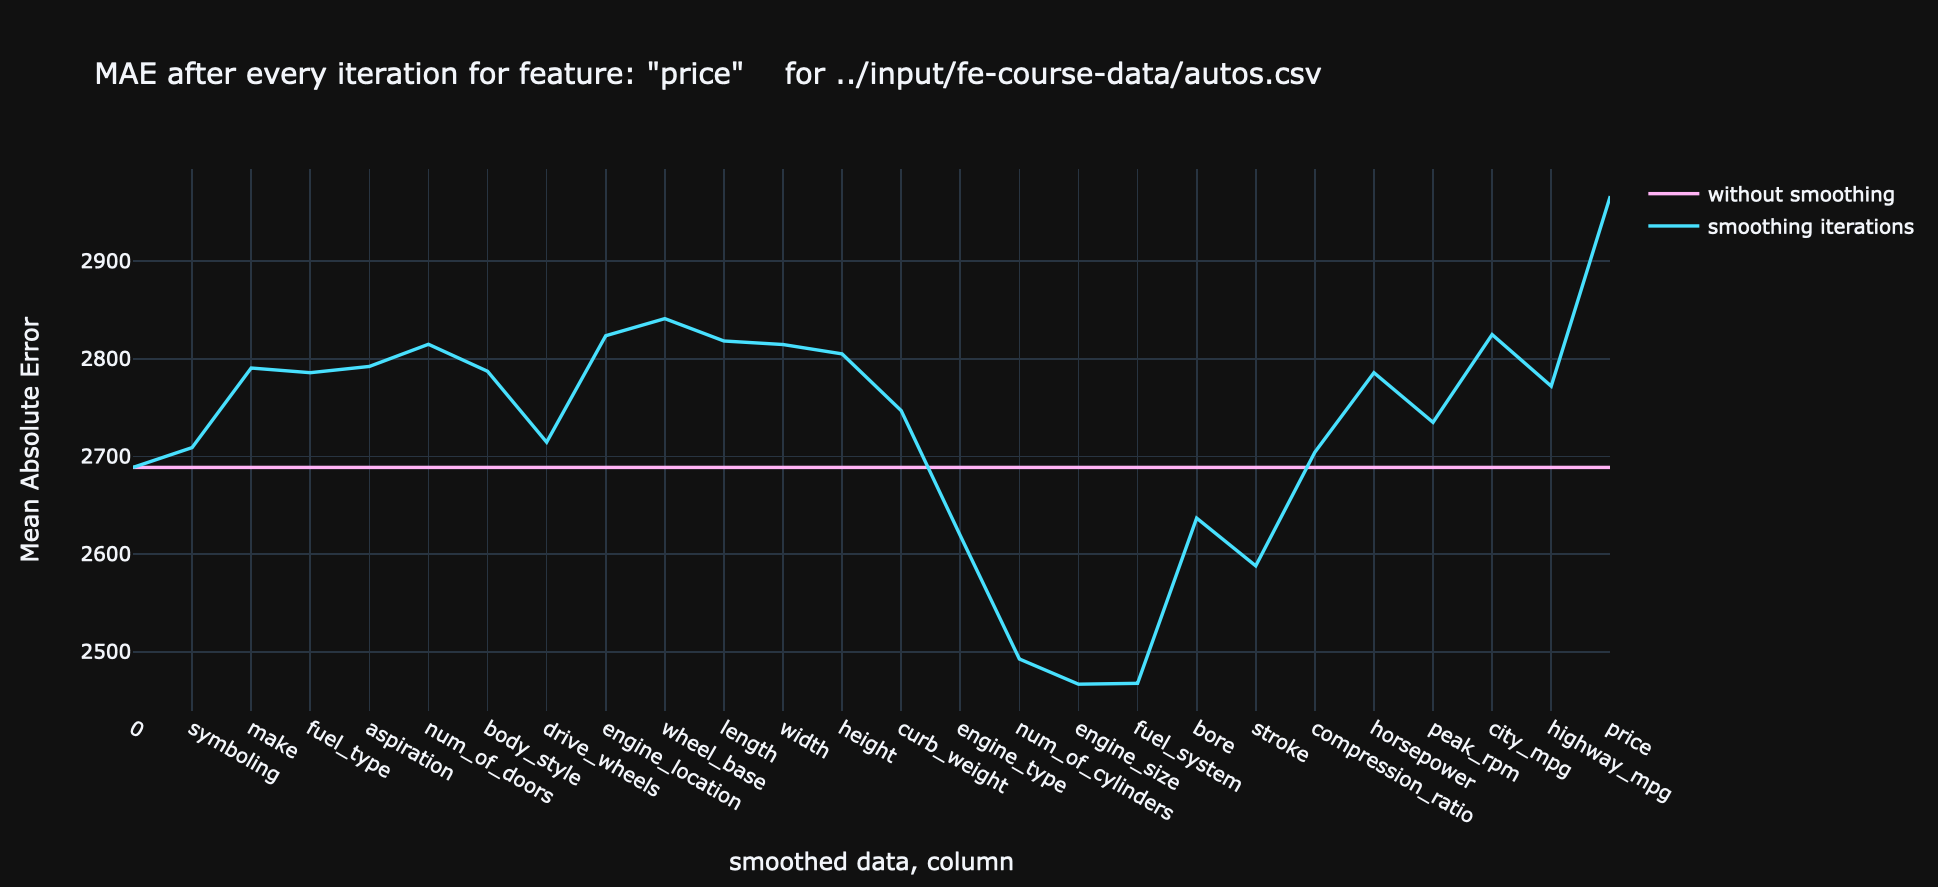